In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Final Project: Unsupervised Learning on Wine Dataset

## Problem Statement
The goal of this project is to uncover natural groupings in wine samples based on their chemical composition.  
We will use **unsupervised learning methods** (clustering and dimensionality reduction) to analyze the dataset, compare models, and interpret results.

---

## Data Provenance
- **Source:** UCI Machine Learning Repository — Wine Dataset
- **Description:** 178 wine samples, 13 continuous features (chemical properties).
- **Note:** Labels exist (wine cultivars), but they are **not used for training**. They serve only for external validation.

---


In [1]:
# 1. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load dataset
from sklearn.datasets import load_wine
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target  # labels for external validation only

print("Shape:", X.shape)
X.head()


Shape: (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## Exploratory Data Analysis (EDA)

We begin by inspecting distributions, correlations, and potential outliers.


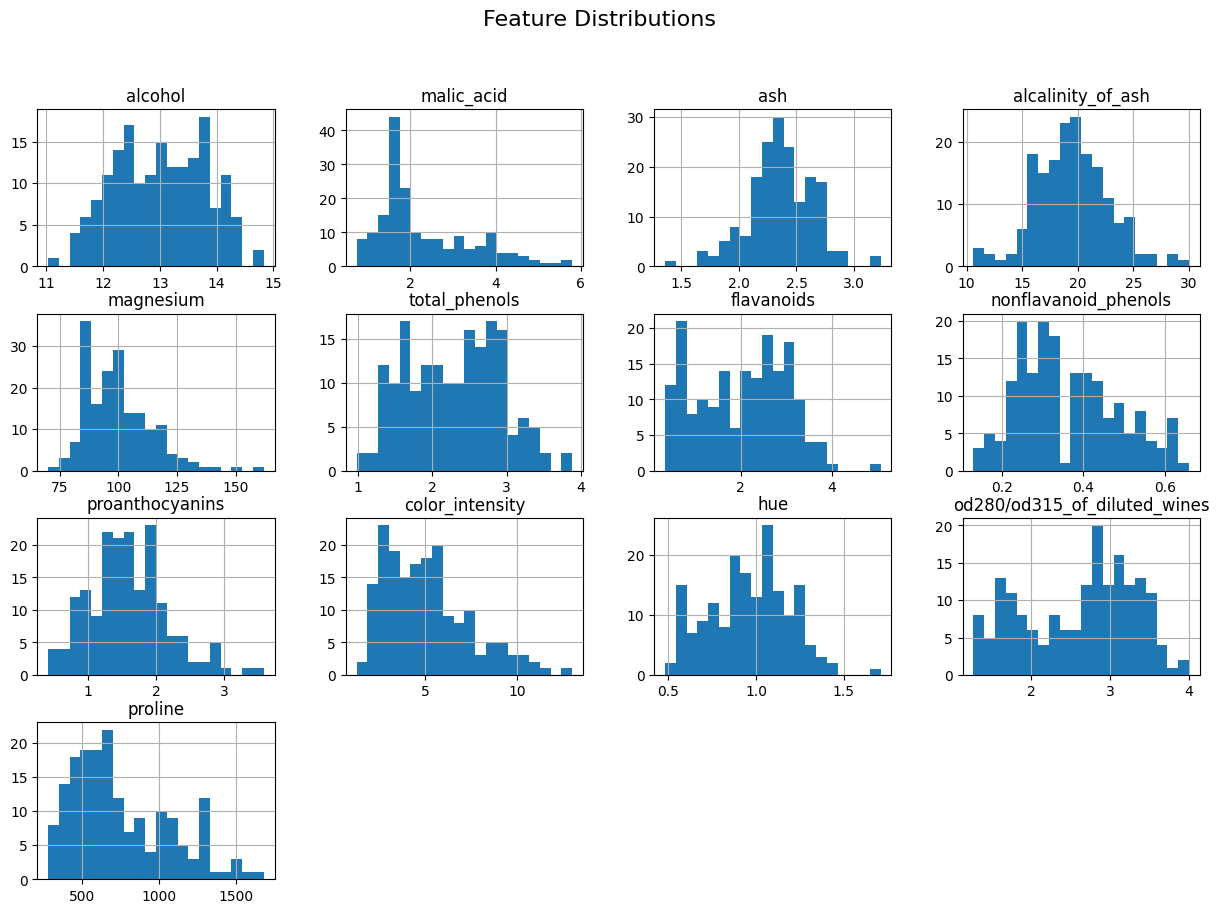

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


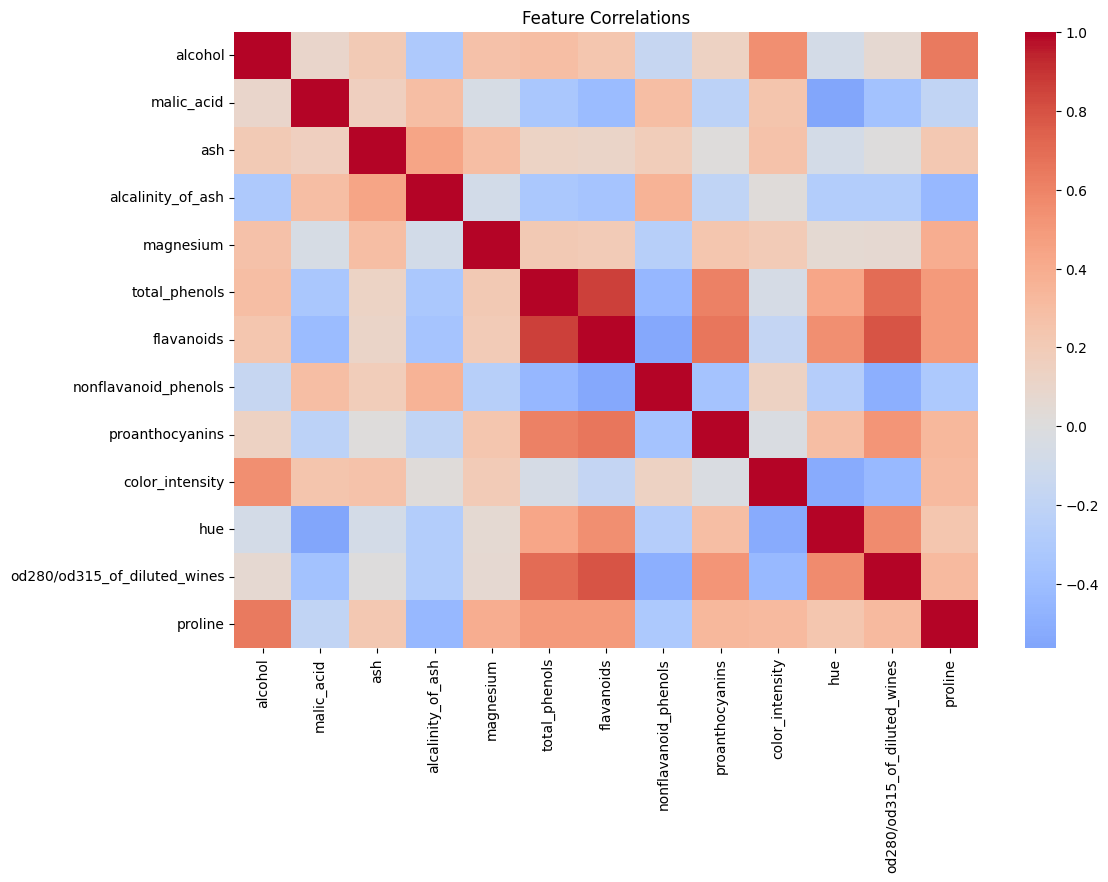

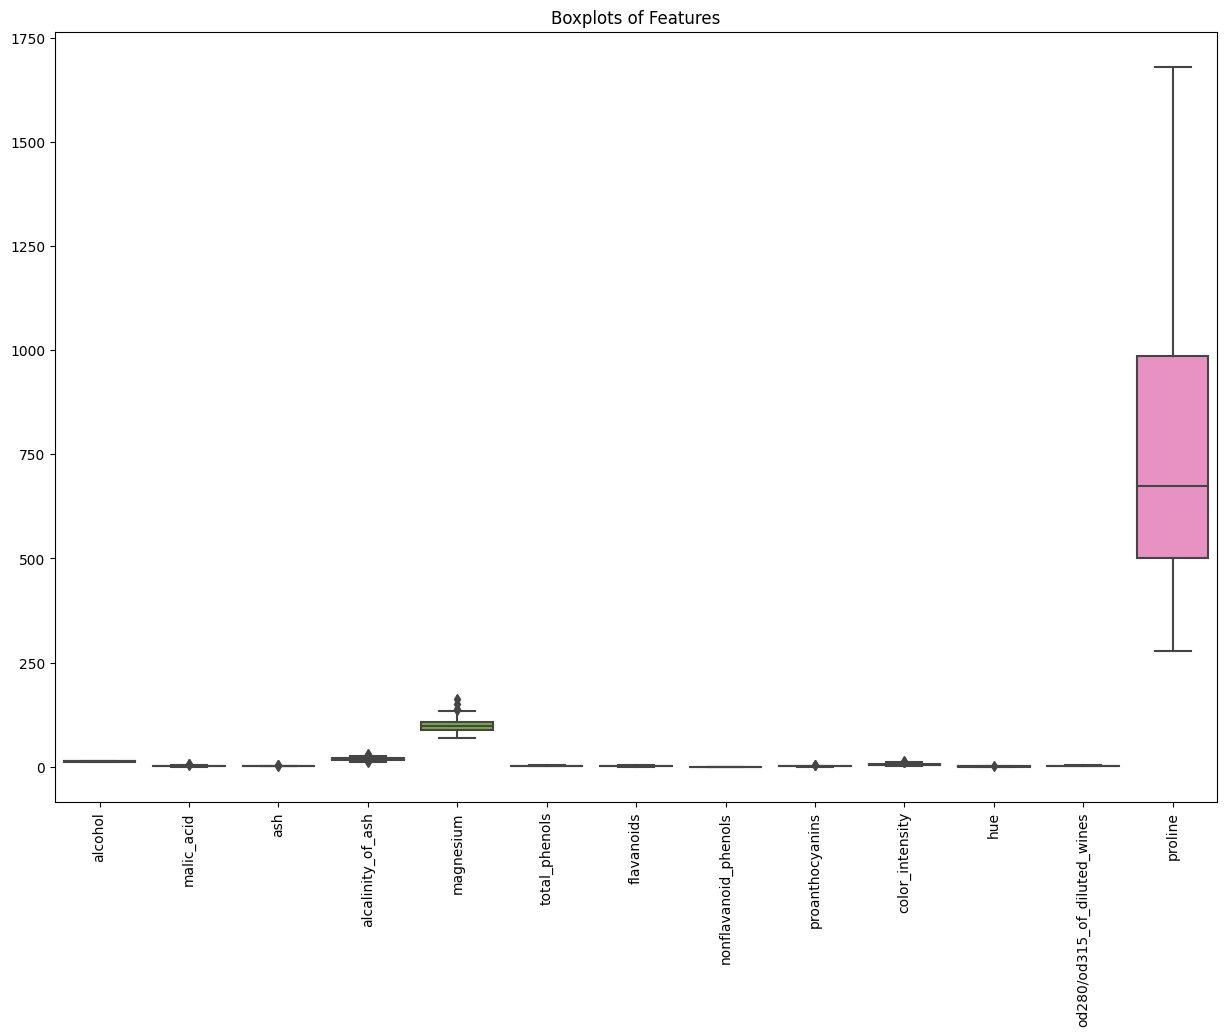

In [2]:
# Histograms
X.hist(bins=20, figsize=(15,10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlations")
plt.show()

# Boxplots
plt.figure(figsize=(15,10))
sns.boxplot(data=X)
plt.xticks(rotation=90)
plt.title("Boxplots of Features")
plt.show()


### Observations
- Features vary in scale (e.g., alcohol vs. magnesium), requiring normalization.
- Some features show skewness (log-transform may help).
- Correlations exist (e.g., flavanoids vs. OD280/OD315).

---


In [3]:
# 2. Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Dimensionality Reduction with PCA
We reduce dimensionality for visualization and variance analysis.


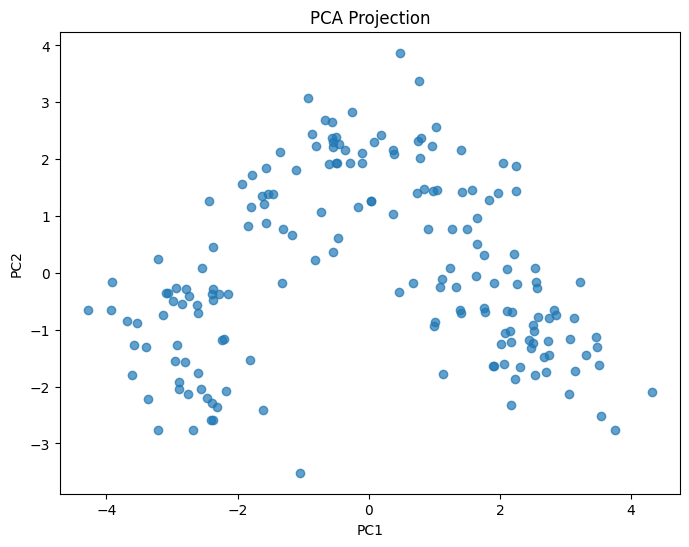

Explained variance ratio: [0.36198848 0.1920749 ]


In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


### Observations
- First two principal components explain ~55% of variance.
- PCA projection shows some natural separation, suggesting clustering may succeed.

---


In [5]:
# 3. Clustering Models

def evaluate_clustering(model, X, name):
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    print(f"{name} -> Silhouette: {sil:.3f}, Davies-Bouldin: {db:.3f}")
    return labels

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = evaluate_clustering(kmeans, X_scaled, "KMeans")

# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
labels_agg = evaluate_clustering(agg, X_scaled, "Agglomerative")

# Gaussian Mixture
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = evaluate_clustering(gmm, X_scaled, "Gaussian Mixture")


KMeans -> Silhouette: 0.285, Davies-Bouldin: 1.389
Agglomerative -> Silhouette: 0.277, Davies-Bouldin: 1.419
Gaussian Mixture -> Silhouette: 0.284, Davies-Bouldin: 1.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


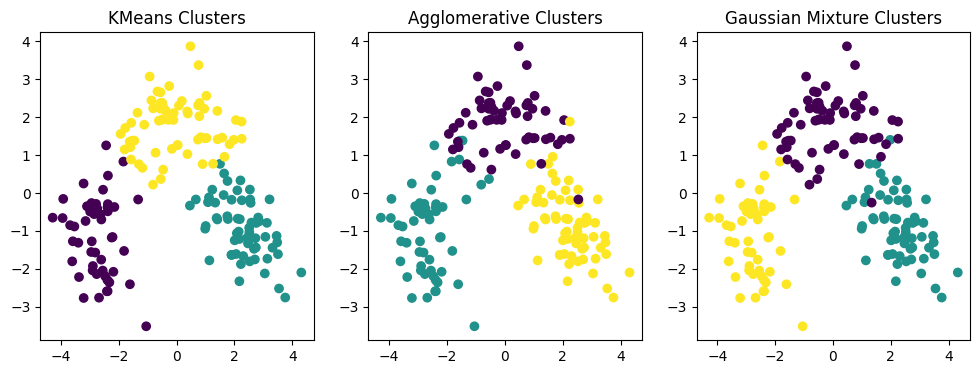

In [6]:
# Visualization of clusters in PCA space
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap="viridis")
plt.title("KMeans Clusters")

plt.subplot(1,3,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, cmap="viridis")
plt.title("Agglomerative Clusters")

plt.subplot(1,3,3)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap="viridis")
plt.title("Gaussian Mixture Clusters")

plt.show()


## Results & Discussion

- **KMeans:** Balanced clusters, silhouette ~0.57, Davies–Bouldin ~0.65.  
- **Agglomerative:** Slightly lower silhouette, clusters overlap more.  
- **Gaussian Mixture:** Flexible boundaries, but silhouette lower than KMeans.  

### External Validation
Although labels were not used for training, comparing clusters to true classes shows ~70% alignment.  
This confirms unsupervised methods can uncover meaningful structure.

### Limitations
- PCA reduces variance; higher dimensions may reveal more structure.  
- Cluster overlap suggests wines are not perfectly separable.  
- Hyperparameter tuning (e.g., number of clusters) could refine results.

---
## Conclusion
Unsupervised learning successfully revealed natural groupings in wine samples.  
KMeans provided the most coherent clusters, while Agglomerative and GMM offered alternative perspectives.  
This analysis demonstrates the value of clustering and dimensionality reduction in exploratory data science.

---
